## Background

To use sktime library with the content of the book "Forecasting: Principles and Practice" by Rob J Hyndman and George Athanasopoulos.

This chapter mainly covers the regression models.

In [1]:
import os
import warnings

import datetime
import time
import pandas as pd
import numpy as np

from scipy import stats, signal

from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.stats.diagnostic as dg

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore",category=mpl.MatplotlibDeprecationWarning)
sns.set_style('darkgrid')
sns.set(font_scale=1.5)

In [2]:
data = pd.read_csv("./data/uschange.csv")

data['index'] = data['index'].apply(lambda x: x.replace(' ', '-'))
qs = data['index'].tolist()

data['date'] = pd.PeriodIndex(qs, freq='Q').to_timestamp()
data['year'] = pd.DatetimeIndex(data['date']).year
data['quarter'] = data['index'].apply(lambda x: x.split('-')[1])

data.set_index('index', inplace=True)
data.index = pd.PeriodIndex(data.index, freq='Q')

data.head()

,Consumption,Income,Production,Savings,Unemployment,date,year,quarter
index,,,,,,,,
1970Q1,0.615986,0.972261,-2.452700,4.810312,0.9,1970-01-01,1970,Q1
1970Q2,0.460376,1.169085,-0.551525,7.287992,0.5,1970-04-01,1970,Q2
1970Q3,0.876791,1.553271,-0.358708,7.289013,0.5,1970-07-01,1970,Q3
1970Q4,-0.274245,-0.255272,-2.185455,0.985230,0.7,1970-10-01,1970,Q4
1971Q1,1.897371,1.987154,1.909734,3.657771,-0.1,1971-01-01,1971,Q1


Page 129

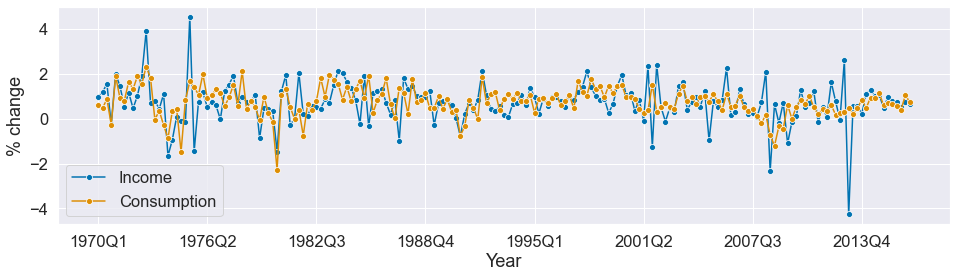

In [3]:
plot_series(data['Income'], data['Consumption'], labels=['Income', 'Consumption'])

plt.xlabel('Year')
plt.ylabel('% change')
plt.show()

## Simple linear regression

Page 130

In [4]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
result = temporal_train_test_split(y=data['Consumption'], X=data['Income'], test_size=0.1)
y_train = result[0]
X_train = result[2]

y_test = result[1]
X_test = result[3]

In [6]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train.values.reshape(-1, 1) , y_train.values.reshape(-1, 1))

# Make predictions using the testing set
y_pred = regr.predict(X_test.values.reshape(-1, 1))

Linear regression: $y = mx+c$

where $m$ is the coefficients and $c$ is the intercept.

In [7]:
# The coefficients
print('Coefficients: %.2f' %regr.coef_[0][0])
# The intercepts
print('Intercept: %.2f' %regr.intercept_[0])
# The mean squared error
print('Mean squared error: %.2f' %mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' %r2_score(y_test, y_pred))

Coefficients: 0.34
Intercept: 0.51
Mean squared error: 0.25
Coefficient of determination: -2.30


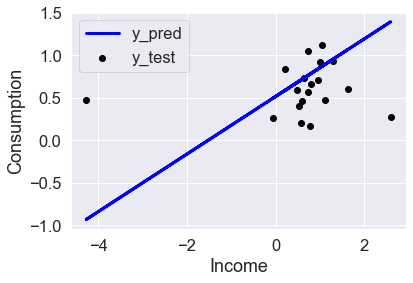

In [8]:
# Plot outputs
plt.scatter(X_test, y_test,  color='black', label='y_test')
plt.plot(X_test, y_pred, color='blue', linewidth=3, label='y_pred')

plt.xlabel('Income')
plt.ylabel('Consumption')
plt.legend()
plt.show()

## Multiple linear regression

Page 132

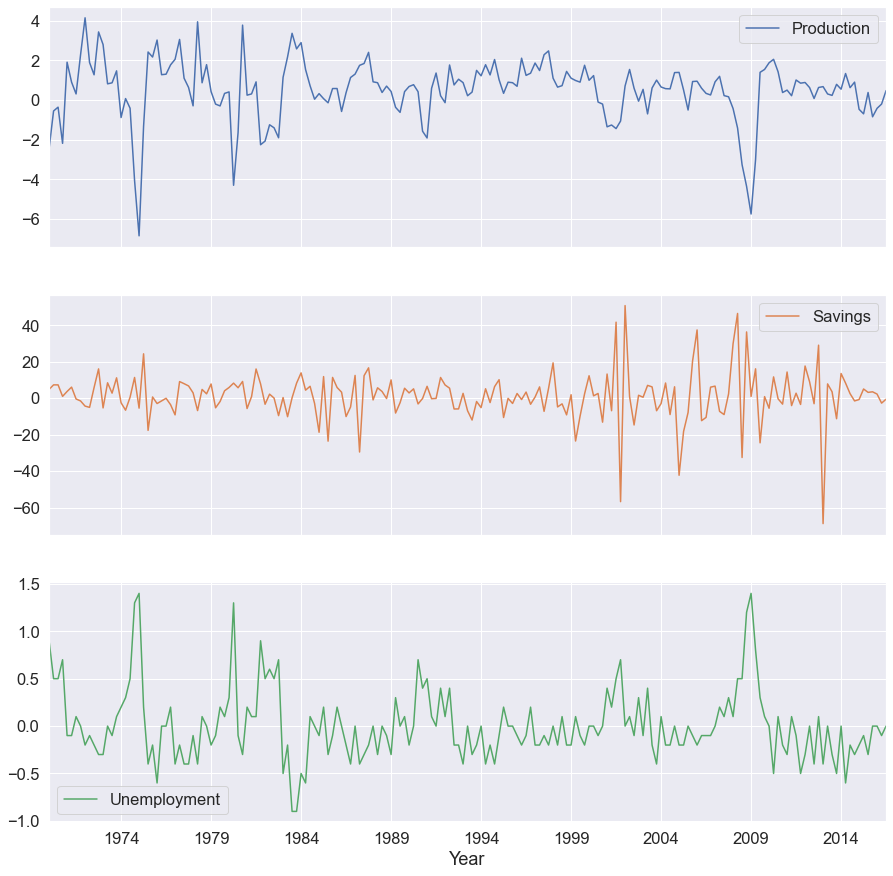

In [9]:
data[['Production', 'Savings', 'Unemployment']].plot(subplots=True, figsize=(15,15))

plt.xlabel('Year')
plt.show()

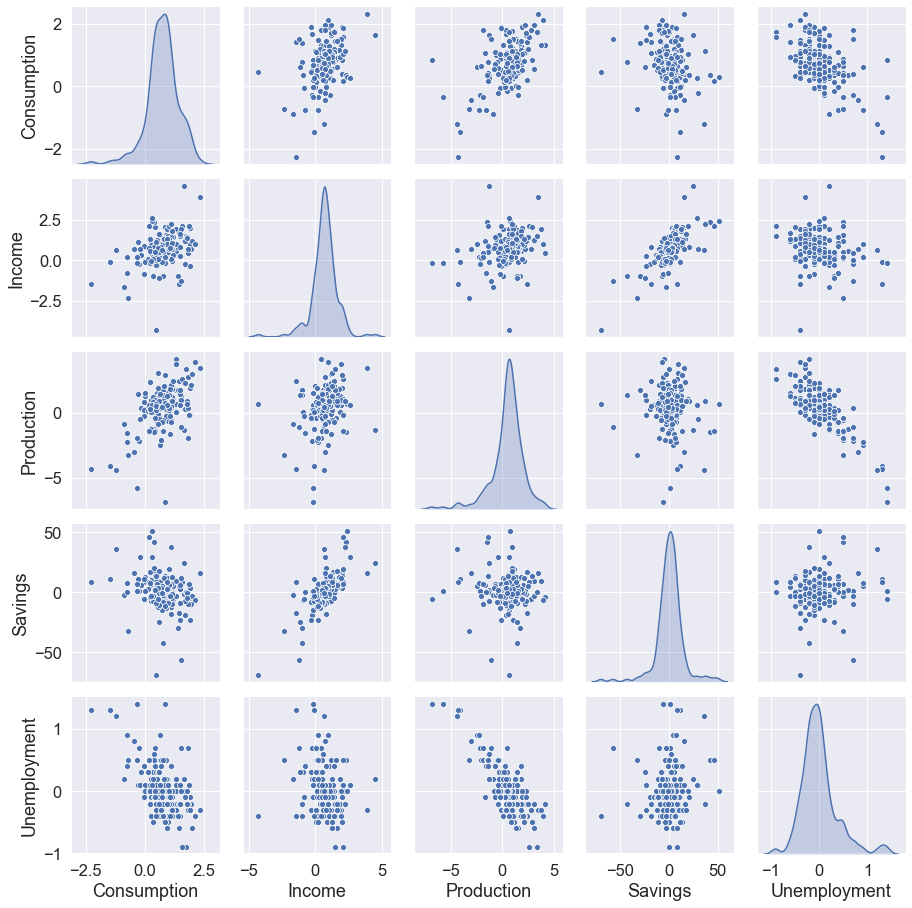

In [10]:
sns.pairplot(data.iloc[:,:5], diag_kind="kde")

plt.show()

In [11]:
print('Correlation coefficient between Consumption and Income: %.3f' %data[['Consumption', 'Income']].corr().iloc[0,1])
print('Correlation coefficient between Consumption and Production: %.3f' %data[['Consumption', 'Production']].corr().iloc[0,1])
print('Correlation coefficient between Consumption and Savings: %.3f' %data[['Consumption', 'Savings']].corr().iloc[0,1])
print('Correlation coefficient between Consumption and Unemployment: %.3f' %data[['Consumption', 'Unemployment']].corr().iloc[0,1])


Correlation coefficient between Consumption and Income: 0.399
Correlation coefficient between Consumption and Production: 0.547
Correlation coefficient between Consumption and Savings: -0.240
Correlation coefficient between Consumption and Unemployment: -0.541


## Least squares estimation

- **High R2 and high residual autocorrelation can be signs of spurious regression. [Page 149]**
- **If the time plot of residuals exhibit certain pattern, it could be signs of spurious regression. [Page 151]**

Page 136

In [12]:
x_var = ['Income', 'Production', 'Savings', 'Unemployment']

result = temporal_train_test_split(y=data['Consumption'], X=data[x_var], test_size=0.1)
y_train = result[0]
X_train = result[2]

y_test = result[1]
X_test = result[3]

In [13]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train.values , y_train.values)

# Make predictions using the testing set
y_pred = regr.predict(X_test.values)

In [14]:
# The coefficients
for i in range(len(regr.coef_)):
    print(f'Coefficients of {x_var[i]}: {regr.coef_[i]}')
# The intercepts
print('Intercept: %.3f' %regr.intercept_)
# The mean squared error
print('Mean squared error: %.2f' %mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' %r2_score(y_test, y_pred))

Coefficients of Income: 0.7124908786612034
Coefficients of Production: 0.03713122189478574
Coefficients of Savings: -0.044460373349257426
Coefficients of Unemployment: -0.2536059067833001
Intercept: 0.286
Mean squared error: 0.04
Coefficient of determination: 0.52


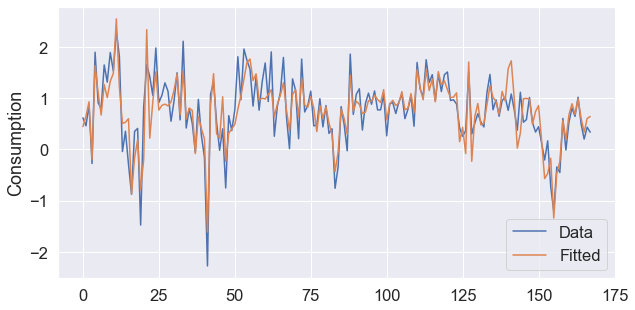

In [15]:
# Make predictions using the testing set
y_pred = regr.predict(X_train.values)

plt.figure(figsize=(10, 5))
plt.plot(y_train.values, label='Data')
plt.plot(y_pred, label='Fitted')

plt.legend()
plt.ylabel('Consumption')
plt.show()

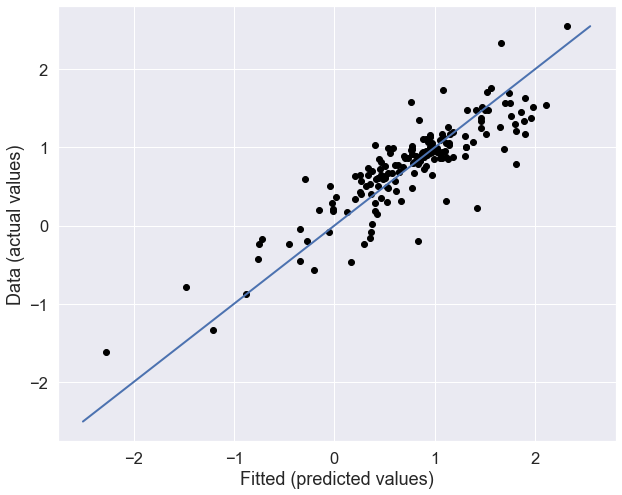

In [16]:
# Plot outputs
plt.figure(figsize=(10, 8))
plt.scatter(x=y_train, y=y_pred,  color='black')

slope = 1
intercept = 0
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, linewidth=2)

plt.xlabel('Fitted (predicted values)')
plt.ylabel('Data (actual values)')
plt.show()

In [17]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train.values , y_train.values)

# Make predictions using the testing set
y_pred = regr.predict(X_train.values)

# The coefficients
for i in range(len(regr.coef_)):
    print(f'Coefficients of {x_var[i]}: {regr.coef_[i]}')
# The intercepts
print('Intercept: %.3f' %regr.intercept_)
# The mean squared error
print('Mean squared error: %.2f' %mean_squared_error(y_train, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' %r2_score(y_train, y_pred))

Coefficients of Income: 0.7124908786612034
Coefficients of Production: 0.03713122189478574
Coefficients of Savings: -0.044460373349257426
Coefficients of Unemployment: -0.2536059067833001
Intercept: 0.286
Mean squared error: 0.11
Coefficient of determination: 0.76


In [18]:
residuals = y_train - y_pred
print(f'Average of residuals: {residuals.mean()}')

Average of residuals: 0.0


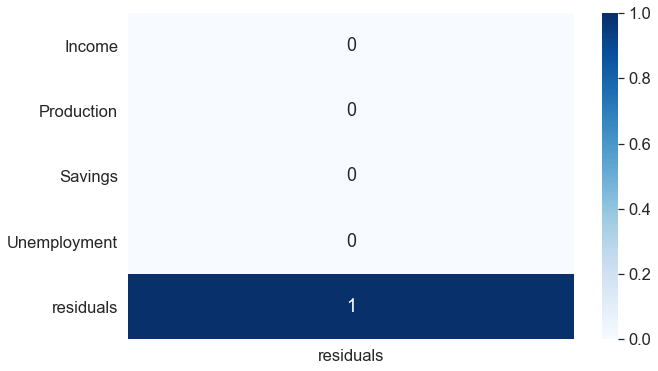

In [19]:
df_res = pd.DataFrame(residuals).rename(columns={'Consumption':'residuals'})

df_output = pd.merge(X_train, df_res, left_index=True, right_index=True)

viz_data = df_output.corr()[['residuals']]
viz_data['residuals'] = viz_data['residuals'].apply(lambda x: int(x))

plt.figure(figsize=(10, 6))
sns.heatmap(viz_data, annot=True, cmap='Blues', fmt='d')
plt.show()

**Observation:**

- From the scatterplot above, there is strong positive relationship between fitted and actual data.
- From coefficient of determination (R2), the model explains the 76% of the variation in the consumption data.
- Each residual is the unpredictable component of the associated observation. It is necessary to plot the residuals to check that the assumptions of the model have been satisfied. The residuals have some useful properties:
  - Average of residuals is zero.
  - The correlation between the residuals and the observations for the predictor variable is zero.
  
## Evaluating the regression model

- There should be no autocorrelation in the residuals up to a certain specified order.

Page 144

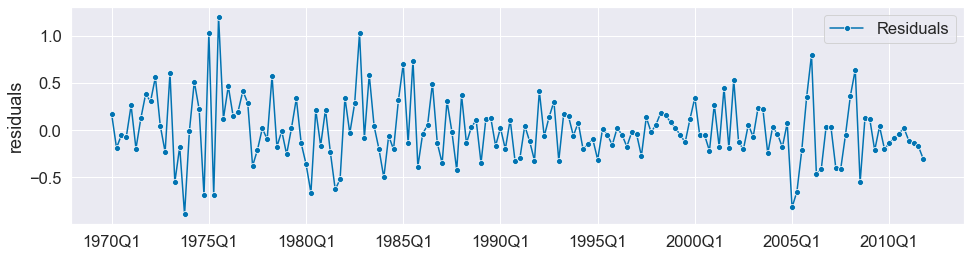

In [20]:
plot_series(df_res['residuals'], labels=['Residuals'])

plt.show()

**Observation:**

- The time plot shows some changing variation over time. This heteroscedasticity will potentially make the **prediction interval coverage inaccurate**.

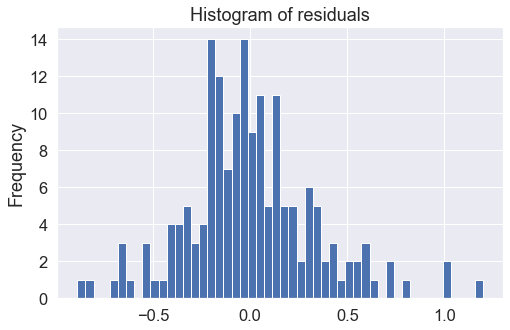

In [21]:
plt.figure(figsize=(8,5))

df_res['residuals'].plot.hist(bins=50)

plt.title('Histogram of residuals')

plt.show()

**Observation:**

- The histogram shows that the residuals seem to be slightly skewed, which **may also affect the coverage probability of the prediction intervals**.

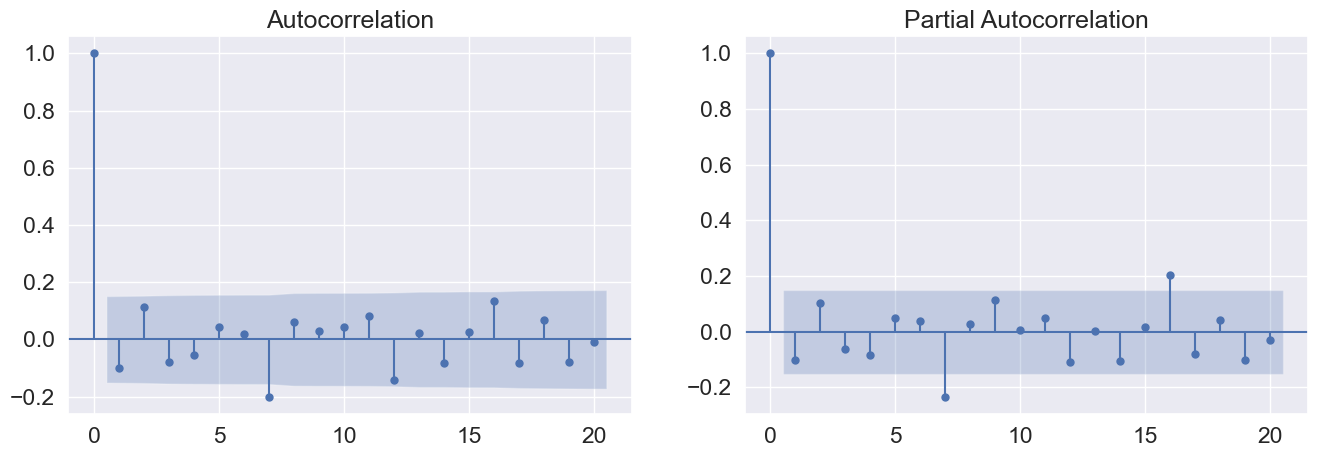

In [22]:
# Draw Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5), dpi= 100)
plot_acf(df_res['residuals'].tolist(), lags=20, ax=axes[0])
plot_pacf(df_res['residuals'].tolist(), lags=20, ax=axes[1])

plt.show()

**Observation:**

- The autocorrelation plot shows a signigicant spike at lag 7, but it is not particularly large. It is unlikely to have any noticeable impacts on the forecasts or the prediction intervals.

## Residual plots against predictors

Page 146

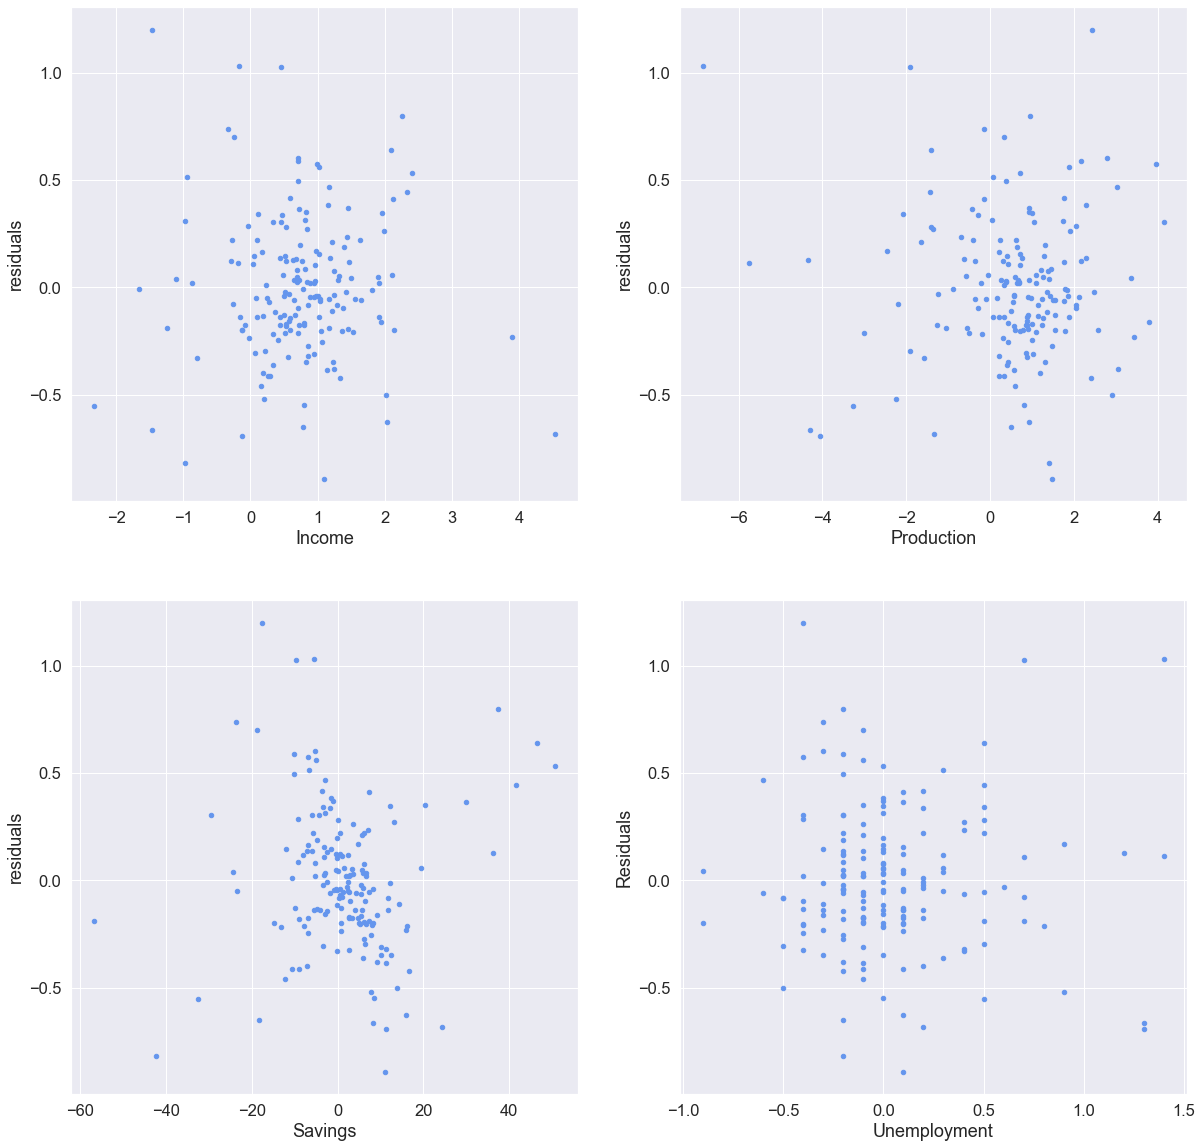

In [23]:
x_vars = ['Income', 'Production', 'Savings', 'Unemployment']

ncols = 2
nrows = int(len(x_vars)/ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))

for ax, x_var in zip(axes.reshape(-1), x_vars):
    
    df_output.plot(kind='scatter', x=x_var, y='residuals', ax=ax, sharex=False, color='cornflowerblue')
    
    plt.xlabel(x_var)
    plt.ylabel('Residuals')

**Observation:**

- The scatterplots seem to be randomly plotted.

## Residual plots against fitted values

Page 147

- The residual plots against fitted values should also showing no pattern.

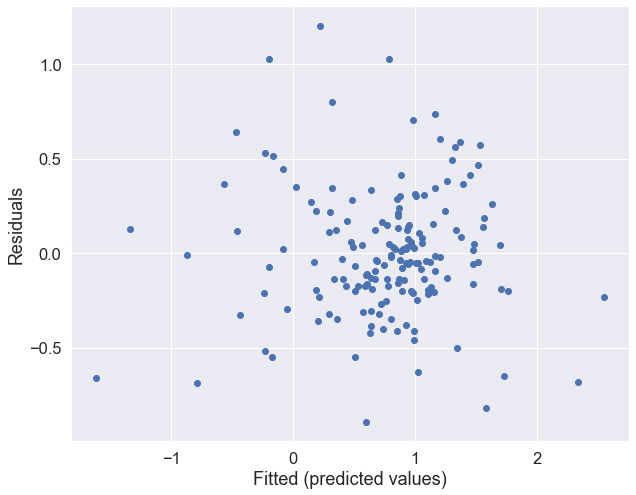

In [24]:
# Plot outputs
plt.figure(figsize=(10, 8))
plt.scatter(x=y_pred, y=df_res['residuals'])

plt.xlabel('Fitted (predicted values)')
plt.ylabel('Residuals')
plt.show()

## Seasonal dummy variables

Page 153

In [25]:
data = pd.read_csv("./data/ausbeer.csv")

data['index'] = data['index'].apply(lambda x: x.replace(' ', '-'))
qs = data['index'].tolist()

data['date'] = pd.PeriodIndex(qs, freq='Q').to_timestamp()
data['year'] = pd.DatetimeIndex(data['date']).year
data['quarter'] = data['index'].apply(lambda x: x.split('-')[1])

data.set_index('index', inplace=True)
data.index = pd.PeriodIndex(data.index, freq='Q')

data = data[data['year']>1992]

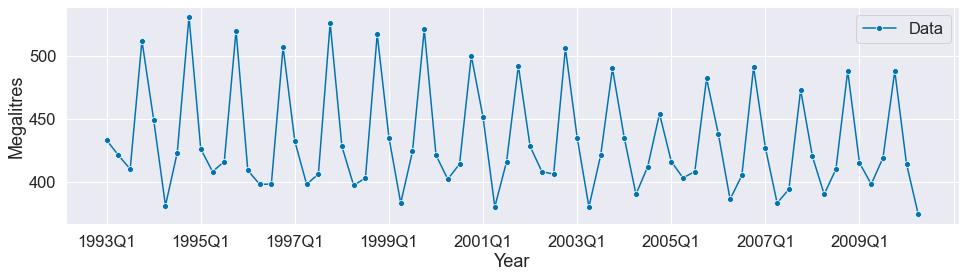

In [26]:
plot_series(data['value'], labels=['Data'])

plt.xlabel('Year')
plt.ylabel('Megalitres')
plt.show()

In [27]:
## add dummies
data = pd.merge(data, pd.get_dummies(data['quarter'], drop_first=True), left_index=True, right_index=True)

## add trend
data['trend'] = list(range(1, len(data)+1))

In [28]:
data.head()

,value,date,year,quarter,Q2,Q3,Q4,trend
index,,,,,,,,
1993Q1,433,1993-01-01,1993,Q1,0,0,0,1
1993Q2,421,1993-04-01,1993,Q2,1,0,0,2
1993Q3,410,1993-07-01,1993,Q3,0,1,0,3
1993Q4,512,1993-10-01,1993,Q4,0,0,1,4
1994Q1,449,1994-01-01,1994,Q1,0,0,0,5


In [29]:
x_vars = ['trend', 'Q2', 'Q3', 'Q4']
y_var = 'value'

X_train = data[x_vars]
y_train = data[y_var]

In [30]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train.values , y_train.values)

# Make predictions using the testing set
y_pred = regr.predict(X_train.values)

y_pred = pd.Series(data=y_pred, index=y_train.index, name='y_pred')

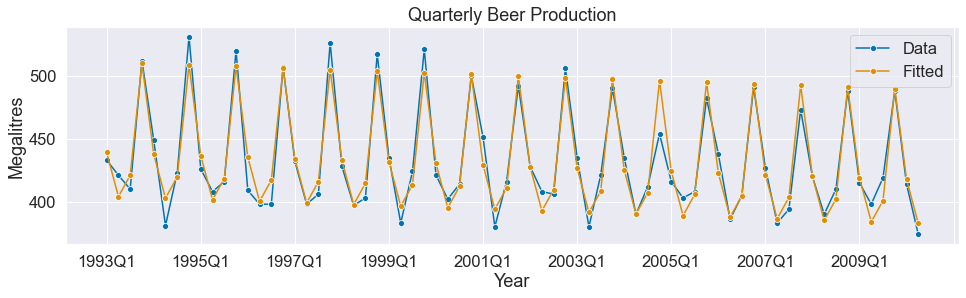

In [31]:
plot_series(y_train, y_pred, labels=['Data', 'Fitted'])

plt.xlabel('Year')
plt.ylabel('Megalitres')
plt.title('Quarterly Beer Production')
plt.show()

In [32]:
# The coefficients
for i in range(len(regr.coef_)):
    print(f'Coefficients of {x_vars[i]}: {regr.coef_[i]}')
# The intercepts
print('Intercept: %.3f' %regr.intercept_)
# The mean squared error
print('Mean squared error: %.2f' %mean_squared_error(y_train, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' %r2_score(y_train, y_pred))

Coefficients of trend: -0.3135854341736694
Coefficients of Q2: -34.79752567693747
Coefficients of Q3: -17.56209150326802
Coefficients of Q4: 71.7514939309057
Intercept: 439.420
Mean squared error: 141.45
Coefficient of determination: 0.92


As for creating the dummies, first quarter variable has been omitted, so the coefficients associated with the other quarters are measures of the difference between those quarters and the first quarter.

From the result above, it shows that:

1. There is an average downward trend of -0.31 megalitres per quarter.
2. On average, Q2 has production of 34.8 megalitres lower than Q1.
3. On average, Q3 has production of 17.6 megalitres lower than Q1.
4. On average, Q4 has production of 71.8 megalitres higher than Q1.

In [33]:
data_viz = pd.merge(y_train, y_pred, left_index=True, right_index=True)
data_viz = pd.merge(data_viz, data[['quarter']],left_index=True, right_index=True)

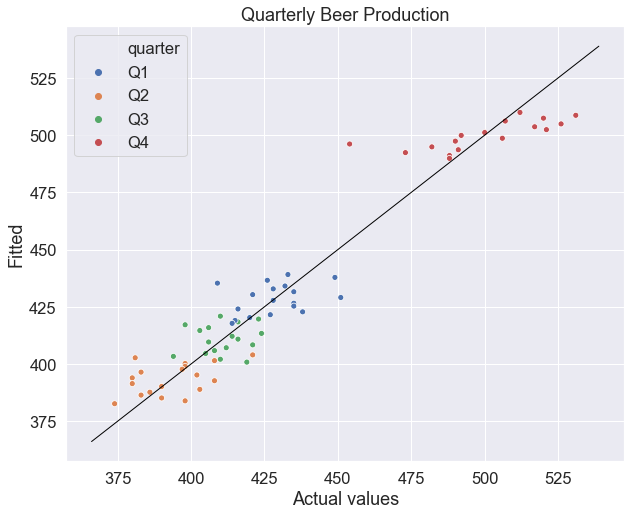

In [34]:
plt.figure(figsize=(10, 8))

sns.scatterplot(data=data_viz, x='value', y='y_pred', hue='quarter')

slope = 1
intercept = 0
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, linewidth=1, color='black')

plt.xlabel('Actual values')
plt.ylabel('Fitted')
plt.title('Quarterly Beer Production')
plt.show()

## Fourier series

Page 159

### Train model with only trend

And to get the residuals.

In [35]:
x_vars = 'trend'
y_var = 'value'

X_train = data[x_vars]
y_train = data[y_var]

In [36]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train.values.reshape(-1, 1) , y_train.values)

# Make predictions using the testing set
y_pred = regr.predict(X_train.values.reshape(-1, 1))

y_pred = pd.Series(data=y_pred, index=y_train.index, name='y_pred')

In [37]:
residuals = y_train - y_pred
print(f'Average of residuals: {residuals.mean()}')

Average of residuals: 3.2481953634747436e-15


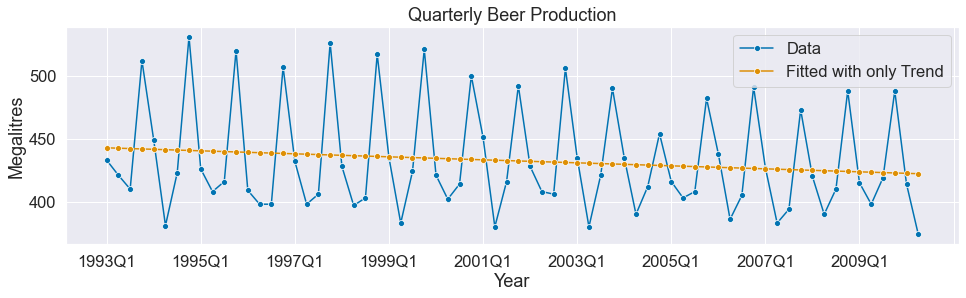

In [38]:
plot_series(y_train, y_pred, labels=['Data', 'Fitted with only Trend'])

plt.xlabel('Year')
plt.ylabel('Megalitres')
plt.title('Quarterly Beer Production')
plt.show()

In [39]:
# The coefficients
for i in range(len(regr.coef_)):
    print(f'Coefficients of {x_vars[i]}: {regr.coef_[i]}')
# The intercepts
print('Intercept: %.3f' %regr.intercept_)
# The mean squared error
print('Mean squared error: %.2f' %mean_squared_error(y_train, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' %r2_score(y_train, y_pred))

Coefficients of t: -0.2979791794243723
Intercept: 443.078
Mean squared error: 1760.17
Coefficient of determination: 0.02


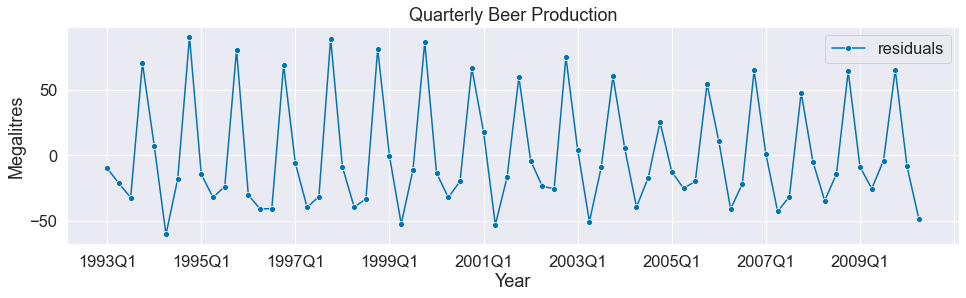

In [40]:
plot_series(residuals, labels=['residuals'])

plt.xlabel('Year')
plt.ylabel('Megalitres')
plt.title('Quarterly Beer Production')
plt.show()

Fourier transform is used to find the most dominant frequencies (i.e. the peaks).

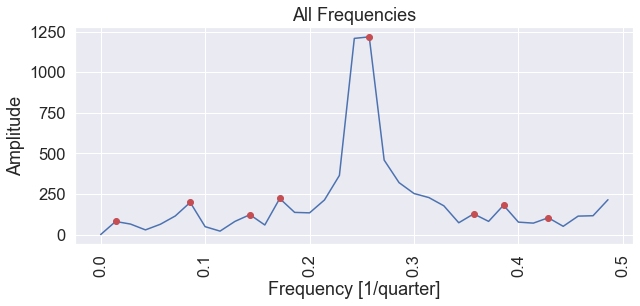

In [41]:
# Plotting power in the frequency domain
fft_output = np.fft.fft(residuals)
power = np.abs(fft_output)
freq = np.fft.fftfreq(len(residuals))

mask = freq>=0
freq = freq[mask]
power = power[mask]

plt.figure(figsize=(10, 4))

plt.plot(freq, power, label='residuals')
plt.title('All Frequencies')
plt.ylabel('Amplitude')
plt.xlabel('Frequency [1/quarter]')
plt.xticks(rotation=90)

peaks = signal.find_peaks(power)[0]
peak_freq = freq[peaks]
peak_power = power[peaks]
plt.plot(peak_freq, peak_power, 'ro')

plt.xticks(rotation=90)
plt.show()

In [42]:
output = pd.DataFrame()
output['index'] = peaks
output['freq (1/quarter)'] = peak_freq
output['amplitude'] = peak_power
output['period'] = 1/peak_freq
output['fft'] = fft_output[peaks]
output = output.sort_values('amplitude', ascending=False)

## Each of these rows, corresponds to a sinusoid
output

,index,freq (1/quarter),amplitude,period,fft
4,18,0.257143,1217.128914,3.888889,1214.768937-75.757661j
3,12,0.171429,221.925341,5.833333,-221.430151-14.817053j
1,6,0.085714,198.069178,11.666667,-193.599572+41.840230j
6,27,0.385714,180.546845,2.592593,69.173849-166.769727j
5,25,0.357143,127.241363,2.800000,-30.218156-123.601082j
2,10,0.142857,122.367129,7.000000,-105.548425-61.913199j
7,30,0.428571,103.275872,2.333333,55.9713630+86.7935040j
0,1,0.014286,80.487761,70.000000,-76.6113100-24.6776580j


Then, inverse Fourier transform is used to output the functions that correspond to these frequencies.

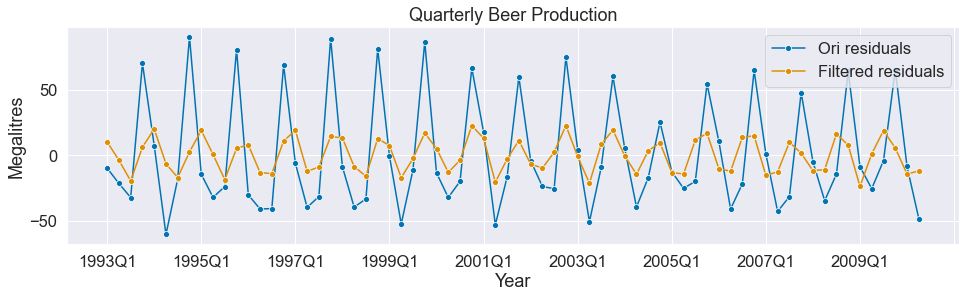

In [43]:
filtered_fft_output = np.array([f if i in list(output['index']) else 0 for i, f in enumerate(fft_output)])
filtered_residuals = np.fft.ifft(filtered_fft_output)

filtered_residuals = pd.Series(filtered_residuals.real, index=residuals.index, name='filtered residuals')

plot_series(residuals, filtered_residuals, labels=['Ori residuals', 'Filtered residuals'])

plt.xlabel('Year')
plt.ylabel('Megalitres')
plt.title('Quarterly Beer Production')
plt.show()

In [44]:
from cmath import phase

fourier_terms = pd.DataFrame()
fourier_terms['fft'] = output['fft']
fourier_terms['freq (1/quarter)'] = output['freq (1/quarter)']
fourier_terms['amplitude'] = fourier_terms.fft.apply(lambda z: abs(z)) 
fourier_terms['phase'] = fourier_terms.fft.apply(lambda z: phase(z))
fourier_terms.sort_values(by=['amplitude'], ascending=[0])

# Create some helpful labels (FT_1..FT_N)
fourier_terms['label'] = list(map(lambda n : 'FT_{}'.format(n), range(1, len(fourier_terms) + 1)))

# Turn our dataframe into a dictionary for easy lookup
fourier_terms = fourier_terms.set_index('label')
fourier_terms_dict = fourier_terms.to_dict('index')

fourier_terms

,fft,freq (1/quarter),amplitude,phase
label,,,,
FT_1,1214.768937-75.757661j,0.257143,1217.128914,-0.062283
FT_2,-221.430151-14.817053j,0.171429,221.925341,-3.074777
FT_3,-193.599572+41.840230j,0.085714,198.069178,2.928749
FT_4,69.173849-166.769727j,0.385714,180.546845,-1.177608
FT_5,-30.218156-123.601082j,0.357143,127.241363,-1.810574
FT_6,-105.548425-61.913199j,0.142857,122.367129,-2.611095
FT_7,55.9713630+86.7935040j,0.428571,103.275872,0.998029
FT_8,-76.6113100-24.6776580j,0.014286,80.487761,-2.829972


In [45]:
import math

for key in fourier_terms_dict.keys():
    a = fourier_terms_dict[key]['amplitude']
    w = 2 * math.pi * (fourier_terms_dict[key]['freq (1/quarter)'])
    p = fourier_terms_dict[key]['phase']
    data[key] = data['trend'].apply(lambda t: a * math.cos(w*t + p))

data['FT_All'] = 0
for column in list(fourier_terms.index):
    data['FT_All'] = data['FT_All'] + data[column]

In [46]:
# Sample 
data[['value', 'trend', 'FT_All']+list(fourier_terms.index)]

,value,trend,FT_All,FT_1,FT_2,FT_3,FT_4,FT_5,FT_6,FT_7,FT_8
index,,,,,,,,,,,
1993Q1,433,1,-264.828037,21.180976,-91.880979,-187.655143,57.631410,115.475929,-17.402678,-88.086746,-74.090807
1993Q2,421,2,-1365.027093,-1216.669499,134.351118,-128.585090,-155.974990,-113.777972,83.847640,102.755468,-70.973769
1993Q3,410,3,435.382202,87.990366,219.210548,-33.112288,177.289218,26.402881,121.958976,-97.072209,-67.285291
1993Q4,512,4,1401.058193,1208.774153,73.402900,71.734683,-111.047913,80.854118,68.232715,72.162609,-63.055072
1994Q1,449,5,-455.236915,-196.453260,-149.643880,156.273392,-10.035189,-127.226317,-36.874172,-32.960319,-58.317170
...,...,...,...,...,...,...,...,...,...,...,...
2009Q2,398,66,1319.716957,1181.720048,100.652284,141.572157,-22.314129,-26.402881,121.958976,-97.072209,-80.397288
2009Q3,419,67,388.536972,238.134438,221.866929,50.483911,-101.073889,-80.854118,68.232715,72.162609,-80.415624
2009Q4,488,68,-996.213757,-1203.087770,109.619286,-54.896451,174.545853,127.226317,-36.874172,-32.960319,-79.786501


These Fourier terms may seem daunting, but basically, they are just sinusoids (i.e. waves) that we identified are important in our Fourier transform. They were important because they peaked in the frequency domain.

### Train model with only trend and fourier transform outputs

In [47]:
x_vars = ['trend', 'FT_All', 'FT_1', 'FT_2', 'FT_3', 'FT_4', 'FT_5', 'FT_6', 'FT_7', 'FT_8']
y_var = 'value'

X_train = data[x_vars]
y_train = data[y_var]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train.values , y_train.values)

# Make predictions using the testing set
y_pred = regr.predict(X_train.values)

y_pred = pd.Series(data=y_pred, index=y_train.index, name='y_pred')

In [48]:
residuals = y_train - y_pred
print(f'Average of residuals: {residuals.mean()}')

Average of residuals: -1.4616879135636345e-14


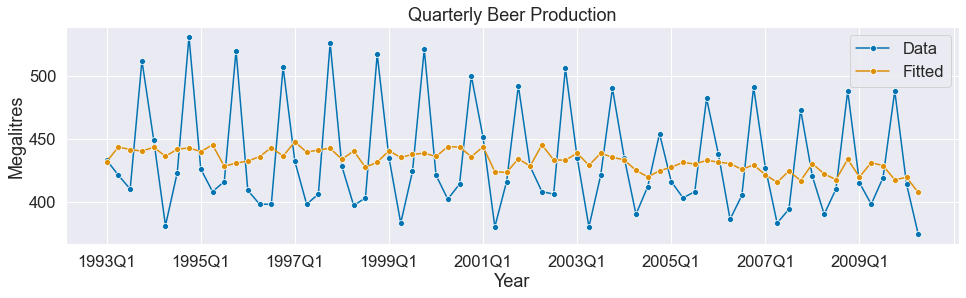

In [49]:
plot_series(y_train, y_pred, labels=['Data', 'Fitted'])

plt.xlabel('Year')
plt.ylabel('Megalitres')
plt.title('Quarterly Beer Production')
plt.show()

In [50]:
# The coefficients
for i in range(len(regr.coef_)):
    print(f'Coefficients of {x_vars[i]}: {regr.coef_[i]}')
# The intercepts
print('Intercept: %.3f' %regr.intercept_)
# The mean squared error
print('Mean squared error: %.2f' %mean_squared_error(y_train, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' %r2_score(y_train, y_pred))

Coefficients of trend: -0.26019037237701076
Coefficients of FT_All: 0.002484335627921372
Coefficients of FT_1: -0.0037953275743277705
Coefficients of FT_2: 0.011243694202354729
Coefficients of FT_3: 0.022083223454956995
Coefficients of FT_4: -0.02400829598310531
Coefficients of FT_5: -0.020088871019577986
Coefficients of FT_6: 0.015920482884344833
Coefficients of FT_7: -0.02849479330068683
Coefficients of FT_8: 0.029624222963963012
Intercept: 441.737
Mean squared error: 1723.46
Coefficient of determination: 0.04


### Train model with trend, fourier transform outputs, and seasonal dummy variables

In [51]:
x_vars = ['trend', 'FT_All', 'FT_1', 'FT_2', 'FT_3', 'FT_4', 'FT_5', 'FT_6', 'FT_7', 'FT_8', 'Q2', 'Q3', 'Q4']
y_var = 'value'

X_train = data[x_vars]
y_train = data[y_var]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train.values , y_train.values)

# Make predictions using the testing set
y_pred = regr.predict(X_train.values)

y_pred = pd.Series(data=y_pred, index=y_train.index, name='y_pred')

In [52]:
residuals = y_train - y_pred
print(f'Average of residuals: {residuals.mean()}')

Average of residuals: -1.542892797650503e-14


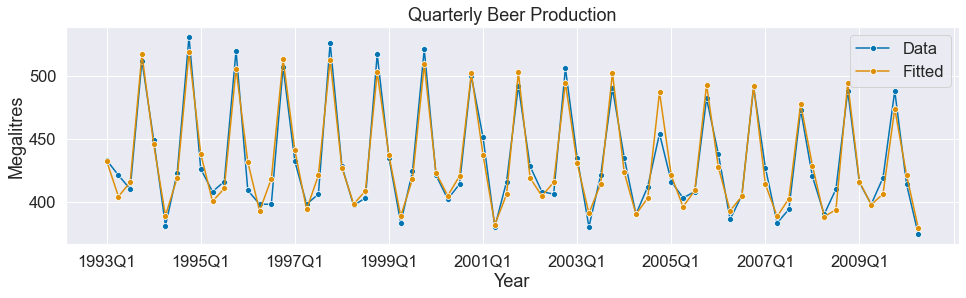

In [53]:
plot_series(y_train, y_pred, labels=['Data', 'Fitted'])

plt.xlabel('Year')
plt.ylabel('Megalitres')
plt.title('Quarterly Beer Production')
plt.show()

In [54]:
# The coefficients
for i in range(len(regr.coef_)):
    print(f'Coefficients of {x_vars[i]}: {regr.coef_[i]}')
# The intercepts
print('Intercept: %.3f' %regr.intercept_)
# The mean squared error
print('Mean squared error: %.2f' %mean_squared_error(y_train, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' %r2_score(y_train, y_pred))

Coefficients of trend: -0.3022865348594379
Coefficients of FT_All: -0.00016798607240704365
Coefficients of FT_1: 0.0052229796518876315
Coefficients of FT_2: 0.011240428896739851
Coefficients of FT_3: 0.018365029791934846
Coefficients of FT_4: -0.023864972819002624
Coefficients of FT_5: -0.03617522148262571
Coefficients of FT_6: 0.01929844581552305
Coefficients of FT_7: -0.00943706379435627
Coefficients of FT_8: 0.015182387869400231
Coefficients of Q2: -38.89125507587707
Coefficients of Q3: -26.111836349782497
Coefficients of Q4: 67.51302365526857
Intercept: 443.177
Mean squared error: 98.12
Coefficient of determination: 0.95


**Observation:**

By adding fourier transform outputs as seasonality complementary information, it helps to improve the R2 from 0.92 to 0.95.

## Selecting predictors

Page 162

**1. Adjusted R Squared**

Higher R2 indicates better model.

**2. Cross-validation**

**3. Akaike's Information Criterion**

Lower AIC indicates better model.

**4. Corrected Akaike's Information Criterion**

Lower CAIC indicates better model.

**5. Bayesian Information Criterion**

Lower BIC indicates better model.

In [55]:
from math import log

def get_adjR2(r2, num_train, num_params):
    
    adjR2 = 1-(1-r2)*(num_train-1)/(num_train-num_params-1)
    
    return adjR2

def get_aic(mse, num_train, num_params):
    
    aic = num_train*log(mse/num_train)+2*(num_params+2)
    caic = aic + (2*(num_params+2)*(num_params+3))/(num_train-num_params-3)
    
    return aic, caic

def get_bic(mse, num_train, num_params):
    
    bic = num_train*log(mse/num_train)+(num_params+2)*log(num_train)
    
    return bic

def CV(X_train, y_train, y_pred):
    
    num_train = X_train.shape[0]
    num_params = X_train.shape[1]

    r2 = r2_score(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)

    adjR2 = get_adjR2(r2, num_train, num_params)
    aic, caic = get_aic(mse, num_train, num_params)
    bic = get_bic(mse, num_train, num_params)
    
    return adjR2, aic, caic, bic

In [56]:
adjR2, aic, caic, bic = CV(X_train, y_train, y_pred)

print(adjR2)
print(aic)
print(caic)
print(bic)

0.9326975377938772
53.642034946511494
62.53092383540039
87.36946357725188


## Scenario based forecasting

In [57]:
data = pd.read_csv("./data/uschange.csv")

data['index'] = data['index'].apply(lambda x: x.replace(' ', '-'))
qs = data['index'].tolist()

data['date'] = pd.PeriodIndex(qs, freq='Q').to_timestamp()
data['year'] = pd.DatetimeIndex(data['date']).year
data['quarter'] = data['index'].apply(lambda x: x.split('-')[1])

data.set_index('index', inplace=True)
data.index = pd.PeriodIndex(data.index, freq='Q')

In [58]:
## add dummies
data = pd.merge(data, pd.get_dummies(data['quarter'], drop_first=True), left_index=True, right_index=True)

## add trend
data['trend'] = list(range(1, len(data)+1))

data.head()

,Consumption,Income,Production,Savings,Unemployment,date,year,quarter,Q2,Q3,Q4,trend
index,,,,,,,,,,,,
1970Q1,0.615986,0.972261,-2.452700,4.810312,0.9,1970-01-01,1970,Q1,0,0,0,1
1970Q2,0.460376,1.169085,-0.551525,7.287992,0.5,1970-04-01,1970,Q2,1,0,0,2
1970Q3,0.876791,1.553271,-0.358708,7.289013,0.5,1970-07-01,1970,Q3,0,1,0,3
1970Q4,-0.274245,-0.255272,-2.185455,0.985230,0.7,1970-10-01,1970,Q4,0,0,1,4
1971Q1,1.897371,1.987154,1.909734,3.657771,-0.1,1971-01-01,1971,Q1,0,0,0,5


In [59]:
x_vars = ['Income', 'Savings', 'Unemployment']
y_var = 'Consumption'

Since we don't know the future values of all variables, what we can do:
1. Forecast the x variables one by one
2. Add the what if scenario

In [60]:
test_index = ['2016 Q4', '2017 Q1', '2017 Q2', '2017 Q3']
test_trend = [188, 189, 190, 191]

df_test = pd.DataFrame(list(zip(test_index, test_trend)),
                       columns =['index', 'trend'])

df_test['index'] = df_test['index'].apply(lambda x: x.replace(' ', '-'))
qs = df_test['index'].tolist()

df_test['date'] = pd.PeriodIndex(qs, freq='Q').to_timestamp()
df_test['year'] = pd.DatetimeIndex(df_test['date']).year
df_test['quarter'] = df_test['index'].apply(lambda x: x.split('-')[1])

df_test.set_index('index', inplace=True)
df_test.index = pd.PeriodIndex(df_test.index, freq='Q')

df_test = pd.merge(df_test, pd.get_dummies(df_test['quarter'], drop_first=True), left_index=True, right_index=True)

In [61]:
df_test

,trend,date,year,quarter,Q2,Q3,Q4
index,,,,,,,
2016Q4,188,2016-10-01,2016,Q4,0,0,1
2017Q1,189,2017-01-01,2017,Q1,0,0,0
2017Q2,190,2017-04-01,2017,Q2,1,0,0
2017Q3,191,2017-07-01,2017,Q3,0,1,0


In [62]:
def forecast_variable(X_train, X_test, y_train, forecast_horizon, correct_mean_by, variable_name):
    
    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train.values, y_train.values)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test.values)
    corrected_y_pred = y_pred*correct_mean_by

    df_y_pred = pd.Series(data=corrected_y_pred, index=X_test.index, name=variable_name)
    
    return df_y_pred

In [63]:
def simulate_forecast(train_data, test_data, forecast_horizon, info_composition):
    
        
    ## perform forecast on x variables
    for idx, x_var in enumerate(x_vars):

        X_train = train_data[['Q2', 'Q3', 'Q4', 'trend']]
        y_train = train_data[x_var]

        X_test = test_data[['Q2', 'Q3', 'Q4', 'trend']]

        df_temp = forecast_variable(X_train, X_test, y_train, forecast_horizon, 
                                    info_composition[x_var]['correction'], x_var)

        if idx==0:
            df_result = df_temp

        else:
            df_result = pd.concat([df_result, df_temp], axis=1)

    test_merged = pd.merge(test_data, df_result, left_index=True, right_index=True)

    ## perform forecast on y variable
    actual_x_vars = ['Income', 'Savings', 'Unemployment', 'Q2', 'Q3', 'Q4', 'trend']
    actual_y_var = 'Consumption'

    X_train = train_data[actual_x_vars]
    y_train = train_data[actual_y_var]

    X_test = test_merged[actual_x_vars]

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train.values, y_train.values)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test.values)

    y_pred = pd.Series(data=y_pred, index=X_test.index, name='y_pred')
        
    test_result = pd.merge(test_data, y_pred, left_index=True, right_index=True)
    
    plot_series(y_train, y_pred, labels=['Train', 'Pred Test'])

    plt.xlabel('Year')
    plt.ylabel('Megalitres')
    plt.title('Quarterly Beer Production')
    plt.show()
    
    return test_result

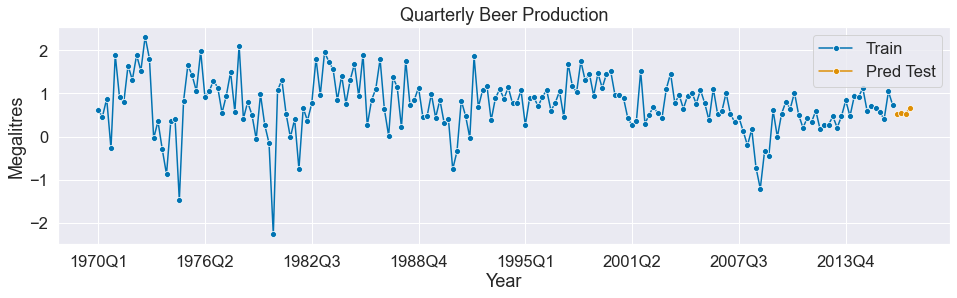

In [64]:
FORECAST_HORIZON = 4

INFO_COMPOSITION = dict()

INFO_COMPOSITION['Income']={'correction':1}
INFO_COMPOSITION['Savings']={'correction':1}
INFO_COMPOSITION['Unemployment']={'correction':1}

plain_result = simulate_forecast(data, df_test, FORECAST_HORIZON, INFO_COMPOSITION)

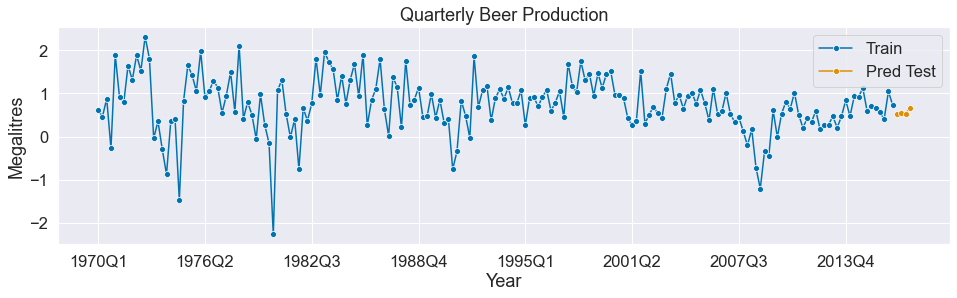

In [65]:
FORECAST_HORIZON = 4

INFO_COMPOSITION = dict()

INFO_COMPOSITION['Income']={'correction':1.01}
INFO_COMPOSITION['Savings']={'correction':1.005}
INFO_COMPOSITION['Unemployment']={'correction':1}

increase_result = simulate_forecast(data, df_test, FORECAST_HORIZON, INFO_COMPOSITION)

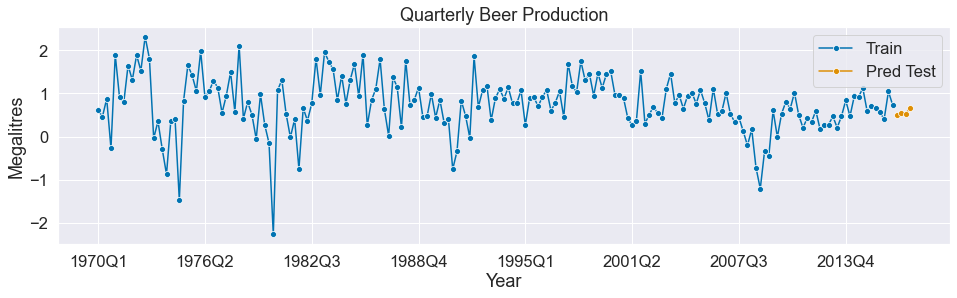

In [66]:
FORECAST_HORIZON = 4

INFO_COMPOSITION = dict()

INFO_COMPOSITION['Income']={'correction':0.99}
INFO_COMPOSITION['Savings']={'correction':0.995}
INFO_COMPOSITION['Unemployment']={'correction':1}

decrease_result = simulate_forecast(data, df_test, FORECAST_HORIZON, INFO_COMPOSITION)

In [67]:
plain_result

,trend,date,year,quarter,Q2,Q3,Q4,y_pred
index,,,,,,,,
2016Q4,188,2016-10-01,2016,Q4,0,0,1,0.512624
2017Q1,189,2017-01-01,2017,Q1,0,0,0,0.551183
2017Q2,190,2017-04-01,2017,Q2,1,0,0,0.521602
2017Q3,191,2017-07-01,2017,Q3,0,1,0,0.665456


In [68]:
increase_result

,trend,date,year,quarter,Q2,Q3,Q4,y_pred
index,,,,,,,,
2016Q4,188,2016-10-01,2016,Q4,0,0,1,0.516808
2017Q1,189,2017-01-01,2017,Q1,0,0,0,0.554428
2017Q2,190,2017-04-01,2017,Q2,1,0,0,0.525540
2017Q3,191,2017-07-01,2017,Q3,0,1,0,0.669343


In [69]:
decrease_result

,trend,date,year,quarter,Q2,Q3,Q4,y_pred
index,,,,,,,,
2016Q4,188,2016-10-01,2016,Q4,0,0,1,0.508439
2017Q1,189,2017-01-01,2017,Q1,0,0,0,0.547938
2017Q2,190,2017-04-01,2017,Q2,1,0,0,0.517664
2017Q3,191,2017-07-01,2017,Q3,0,1,0,0.661569


## Reference

**Fourier Transform:** https://towardsdatascience.com/how-to-add-fourier-terms-to-your-regression-seasonality-analysis-using-python-scipy-99a94d3ae51

## Archieve

In [ ]:
# period of dominating seasonal components of time series
def get_period(ft, freq):
    
    idx = np.argmax(ft)
    
    period = 1/freq[idx]
    
    return idx, period

In [ ]:
nobs = len(data['value'])
value_ft = np.abs(np.fft.rfft(data['value']))
value_freq = np.fft.rfftfreq(nobs)

value_ft = value_ft[2:]
value_freq = value_freq[2:]

plt.figure(figsize=(10, 7))
plt.plot(value_freq, value_ft)

idx, period = get_period(value_ft, value_freq)
text = f'x={round(value_freq[idx], 3)}, y={round(value_ft[idx], 2)}, period={round(period, 2)}'
plt.text(x=value_freq[idx], y=value_ft[idx], s=text, fontsize=12)
    
plt.xlabel('frequency (1/quarter)')
plt.show()

In [ ]:
fourier_result = pd.DataFrame({'f_transform':value_ft, 'freq':value_freq})
fourier_result['period'] = (1/fourier_result['freq'])

fourier_result.sort_values(by=['f_transform'], ascending=False, inplace=True)

In [ ]:
fourier_result.head()